In [11]:
pip install pytorch-fid

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, pathlib
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision, torchvision.datasets, torchvision.transforms, torchvision.utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
# Setup hyperparameters
latent_dim = 100
num_classes = 10
image_size = 32
channels = 3
batch_size = 64
lr_g = 0.0002
lr_d = 0.0001
epochs = 60

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform = transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(110, 512*4*4),
            nn.ReLU()
        )
        self.conv =nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        x = torch.cat([noise, labels], dim=1)
        x = self.linear(x)
        x = x.view(-1, 512, 4, 4)
        x = self.conv(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(13, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        self.linear = nn.Sequential(
            nn.Linear(512*4*4,1),
            nn.Sigmoid()
        )

    def forward(self, input_, labels):
        x = torch.cat([input_, labels], dim=1)
        x = self.conv(x)
        x = x.view(-1, 512*4*4)
        x = self.linear(x)
        return x

In [6]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
loss = nn.BCELoss()
opt_g = optim.Adam(generator.parameters(),lr=lr_g, betas=(0.5, 0.999))
opt_d = optim.Adam(discriminator.parameters(),lr=lr_d, betas=(0.5, 0.999))

In [8]:
# Run only when running on Google Colab and want to save weights to drive
'''from google.colab import drive
drive.mount('/content/drive')'''

Mounted at /content/drive


In [9]:

generator.train()
discriminator.train()

for epoch in range(epochs):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        current_batch_size = images.shape[0]
        noise = torch.randn(current_batch_size, latent_dim).to(device)
        real_labels = torch.ones(current_batch_size, 1).to(device) * 0.9
        fake_labels = torch.zeros(current_batch_size, 1).to(device)
        labels_onehot = nn.functional.one_hot(labels, num_classes).float()
        fake_images = generator(noise, labels=labels_onehot)

        label_map = labels_onehot.view(-1, num_classes,1,1).expand(-1, num_classes,32,32)
        disc_preds = discriminator(images, label_map)

        loss_real = loss(disc_preds, real_labels)

        disc_preds_fake = discriminator(fake_images.detach(), label_map)
        loss_fake = loss(disc_preds_fake, fake_labels)

        loss_d = loss_real + loss_fake

        opt_d.zero_grad()
        loss_d.backward()
        opt_d.step()

        fake_images_gen = generator(noise, labels=labels_onehot)
        disc_preds_gen = discriminator(fake_images_gen, label_map)
        loss_g = loss(disc_preds_gen, real_labels)
        opt_g.zero_grad()
        loss_g.backward()
        opt_g.step()

    print(f"Epoch [{epoch+1}/{epochs}] Loss_D: {loss_d.item():.4f} Loss_G: {loss_g.item():.4f}")
    '''if (epoch + 1) % 10 == 0:
      torch.save(generator.state_dict(),
          f'/content/drive/MyDrive/generator_epoch{epoch+1}.pth')
      torch.save(discriminator.state_dict(),
          f'/content/drive/MyDrive/discriminator_epoch{epoch+1}.pth')
      print(f"Saved checkpoint at epoch {epoch+1}")''' #Run only when running on google colab and want to save weights in drive

Epoch [1/60] Loss_D: 0.5762 Loss_G: 2.8596
Epoch [2/60] Loss_D: 0.7555 Loss_G: 5.5907
Epoch [3/60] Loss_D: 0.5220 Loss_G: 2.2862
Epoch [4/60] Loss_D: 0.5120 Loss_G: 3.7310
Epoch [5/60] Loss_D: 0.4109 Loss_G: 3.2921
Epoch [6/60] Loss_D: 0.5085 Loss_G: 2.2066
Epoch [7/60] Loss_D: 0.3623 Loss_G: 4.6801
Epoch [8/60] Loss_D: 0.7140 Loss_G: 2.3707
Epoch [9/60] Loss_D: 0.4913 Loss_G: 3.3383
Epoch [10/60] Loss_D: 0.5833 Loss_G: 2.3530
Saved checkpoint at epoch 10
Epoch [11/60] Loss_D: 0.5445 Loss_G: 4.0801
Epoch [12/60] Loss_D: 0.7438 Loss_G: 1.7774
Epoch [13/60] Loss_D: 0.3954 Loss_G: 4.2386
Epoch [14/60] Loss_D: 0.4256 Loss_G: 3.6276
Epoch [15/60] Loss_D: 0.4519 Loss_G: 3.7526
Epoch [16/60] Loss_D: 0.4128 Loss_G: 3.1126
Epoch [17/60] Loss_D: 0.4078 Loss_G: 4.9706
Epoch [18/60] Loss_D: 0.4839 Loss_G: 4.7601
Epoch [19/60] Loss_D: 0.6836 Loss_G: 5.5435
Epoch [20/60] Loss_D: 0.3796 Loss_G: 3.8145
Saved checkpoint at epoch 20
Epoch [21/60] Loss_D: 0.3721 Loss_G: 3.9239
Epoch [22/60] Loss_D: 0.492

<All keys matched successfully>

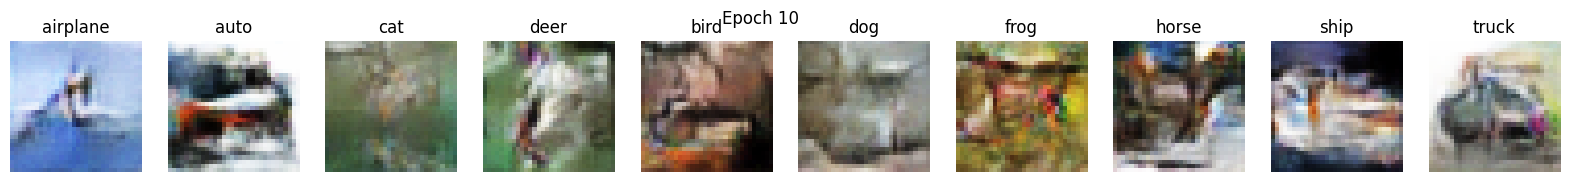

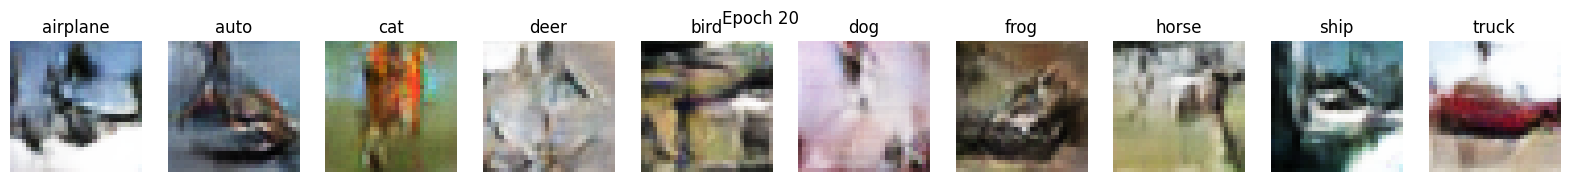

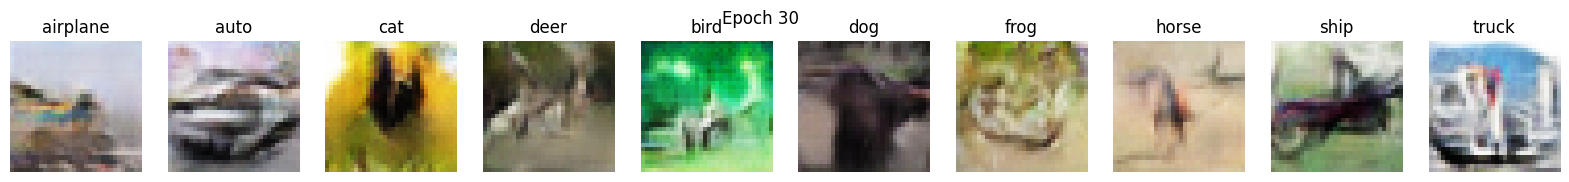

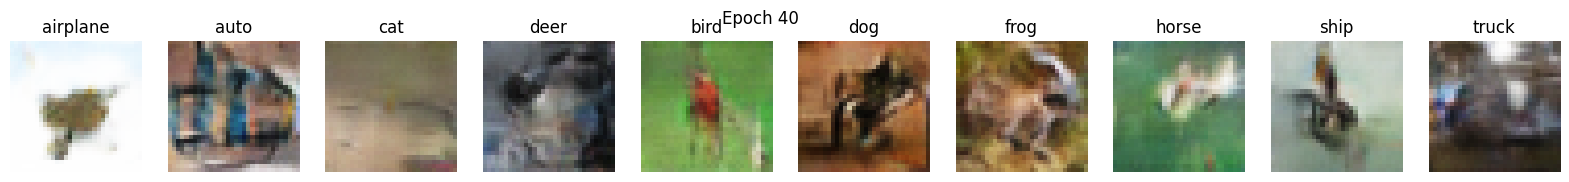

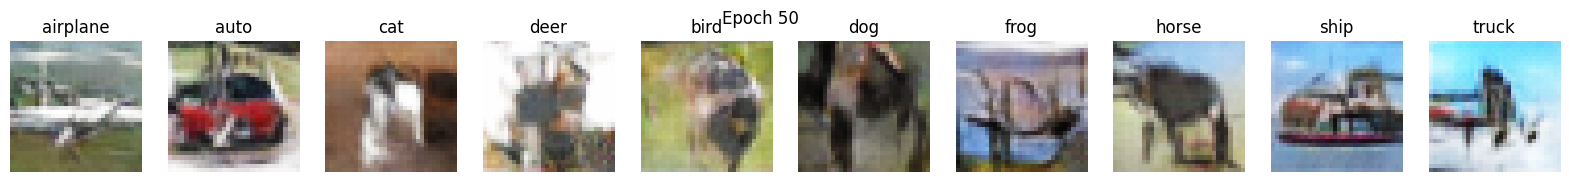

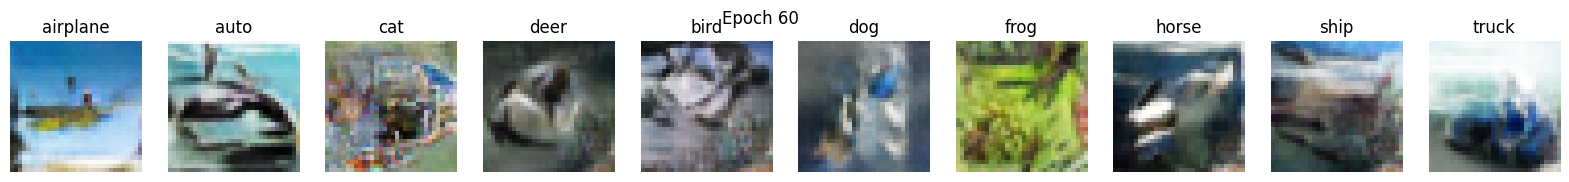

In [9]:
for epoch_num in [10, 20, 30, 40, 50, 60]:
    generator.load_state_dict(torch.load(f'model_weights/generator_epoch{epoch_num}.pth', map_location='cpu'))
    generator.eval()
    with torch.no_grad():
        sample_noise = torch.randn(10, latent_dim)
        sample_labels = torch.arange(10)
        sample_labels_onehot = nn.functional.one_hot(sample_labels, num_classes).float()
        sample_images = generator(sample_noise, sample_labels_onehot)
        sample_images = (sample_images + 1) / 2

    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    fig.suptitle(f'Epoch {epoch_num}')
    for i, ax in enumerate(axes):
        ax.imshow(sample_images[i].cpu().permute(1,2,0).numpy())
        ax.set_title(["airplane","auto","cat","deer","bird","dog","frog","horse","ship","truck"][i])
        ax.axis("off")
    plt.show()

In [10]:
# model at epoch 40 is supposedly better
generator.load_state_dict(torch.load('model_weights/generator_epoch40.pth', map_location='cpu'))
discriminator.load_state_dict(torch.load('model_weights/discriminator_epoch40.pth', map_location='cpu'))

<All keys matched successfully>

In [12]:
import os
from torchvision.utils import save_image

os.makedirs('fid_real', exist_ok=True)
os.makedirs('fid_fake', exist_ok=True)

# Save real images
for i, (images, _) in enumerate(test_loader):
    for j, img in enumerate(images):
        img = (img + 1) / 2  # denormalize
        save_image(img, f'fid_real/{i*batch_size+j}.png')
    if i >= 10:
        break

generator.eval()
idx = 0
with torch.no_grad():
    for i in range(10):  # 10 batches × 64 = 640 images
        noise = torch.randn(batch_size, latent_dim)
        # generate random labels for each image in batch
        labels = torch.randint(0, num_classes, (batch_size,))
        labels_onehot = nn.functional.one_hot(labels, num_classes).float()
        fake_images = generator(noise, labels_onehot)
        fake_images = (fake_images + 1) / 2  # denormalize
        for img in fake_images:
            save_image(img, f'fid_fake/{idx}.png')
            idx += 1

In [13]:
import subprocess
result = subprocess.run(
    ['python', '-m', 'pytorch_fid', 'fid_real', 'fid_fake'],
    capture_output=True, text=True
)
print(result.stdout)
print(result.stderr)

FID:  103.76908684450336

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /Users/sgx/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth

  0%|          | 0.00/91.2M [00:00<?, ?B/s]
  2%|▏         | 1.41M/91.2M [00:00<00:06, 14.7MB/s]
  3%|▎         | 2.81M/91.2M [00:00<00:10, 8.78MB/s]
  5%|▌         | 4.59M/91.2M [00:00<00:07, 12.0MB/s]
  7%|▋         | 6.36M/91.2M [00:00<00:06, 14.0MB/s]
  9%|▊         | 7.85M/91.2M [00:00<00:09, 8.78MB/s]
 10%|▉         | 8.98M/91.2M [00:00<00:09, 8.89MB/s]
 11%|█         | 10.0M/91.2M [00:01<00:10, 7.88MB/s]
 12%|█▏        | 10.9M/91.2M [00:01<00:14, 5.84MB/s]
 13%|█▎        | 11.6M/91.2M [00:01<00:14, 5.64MB/s]
 13%|█▎        | 12.2M/91.2M [00:01<00:20, 3.99MB/s]
 14%|█▍        | 12.8M/91.2M [00:02<00:20, 4.11MB/s]
 15%|█▍        | 13.2M/91.2M [00:02<00:19, 4.23MB/s]
 15%|█▌        | 13.7M/91.2M [00:02<00:18, 4.37MB/s]
 16%|█▌        | 14.2M/91.2M [00:02<00

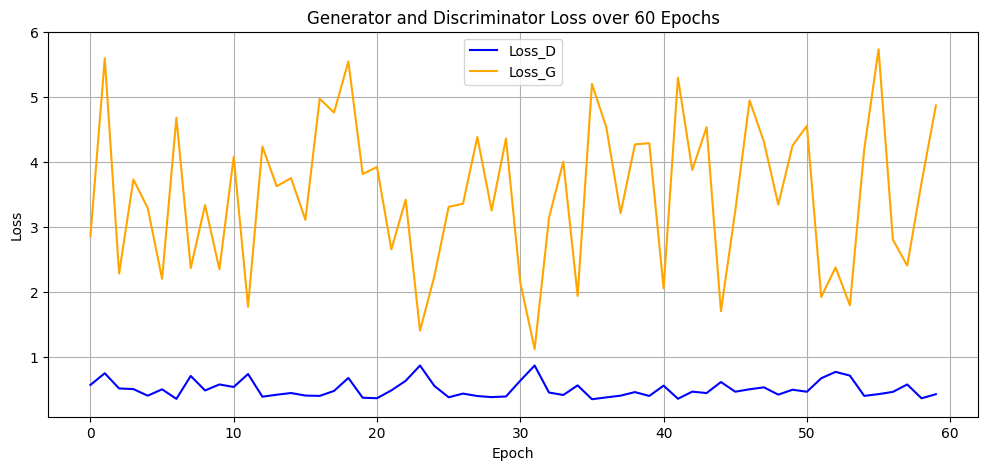

In [14]:
loss_d_values = [0.5762, 0.7555, 0.5220, 0.5120, 0.4109, 0.5085, 0.3623, 0.7140, 0.4913, 0.5833,
                 0.5445, 0.7438, 0.3954, 0.4256, 0.4519, 0.4128, 0.4078, 0.4839, 0.6836, 0.3796,
                 0.3721, 0.4923, 0.6393, 0.8743, 0.5610, 0.3862, 0.4431, 0.4057, 0.3886, 0.3986,
                 0.6421, 0.8740, 0.4595, 0.4214, 0.5693, 0.3566, 0.3846, 0.4115, 0.4660, 0.4069,
                 0.5654, 0.3636, 0.4728, 0.4512, 0.6206, 0.4721, 0.5096, 0.5390, 0.4272, 0.5024,
                 0.4714, 0.6788, 0.7765, 0.7193, 0.4078, 0.4348, 0.4691, 0.5833, 0.3708, 0.4336]

loss_g_values = [2.8596, 5.5907, 2.2862, 3.7310, 3.2921, 2.2066, 4.6801, 2.3707, 3.3383, 2.3530,
                 4.0801, 1.7774, 4.2386, 3.6276, 3.7526, 3.1126, 4.9706, 4.7601, 5.5435, 3.8145,
                 3.9239, 2.6573, 3.4217, 1.4096, 2.2446, 3.3108, 3.3588, 4.3841, 3.2547, 4.3613,
                 2.1445, 1.1272, 3.1394, 4.0041, 1.9424, 5.1978, 4.5344, 3.2135, 4.2705, 4.2882,
                 2.0596, 5.2943, 3.8779, 4.5351, 1.7079, 3.2492, 4.9444, 4.3114, 3.3458, 4.2530,
                 4.5548, 1.9281, 2.3814, 1.8000, 4.1934, 5.7318, 2.8068, 2.4092, 3.6828, 4.8675]

plt.figure(figsize=(12, 5))
plt.plot(loss_d_values, label='Loss_D', color='blue')
plt.plot(loss_g_values, label='Loss_G', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss over 60 Epochs')
plt.legend()
plt.grid(True)
plt.savefig('loss_curve.png', dpi=150)
plt.show()

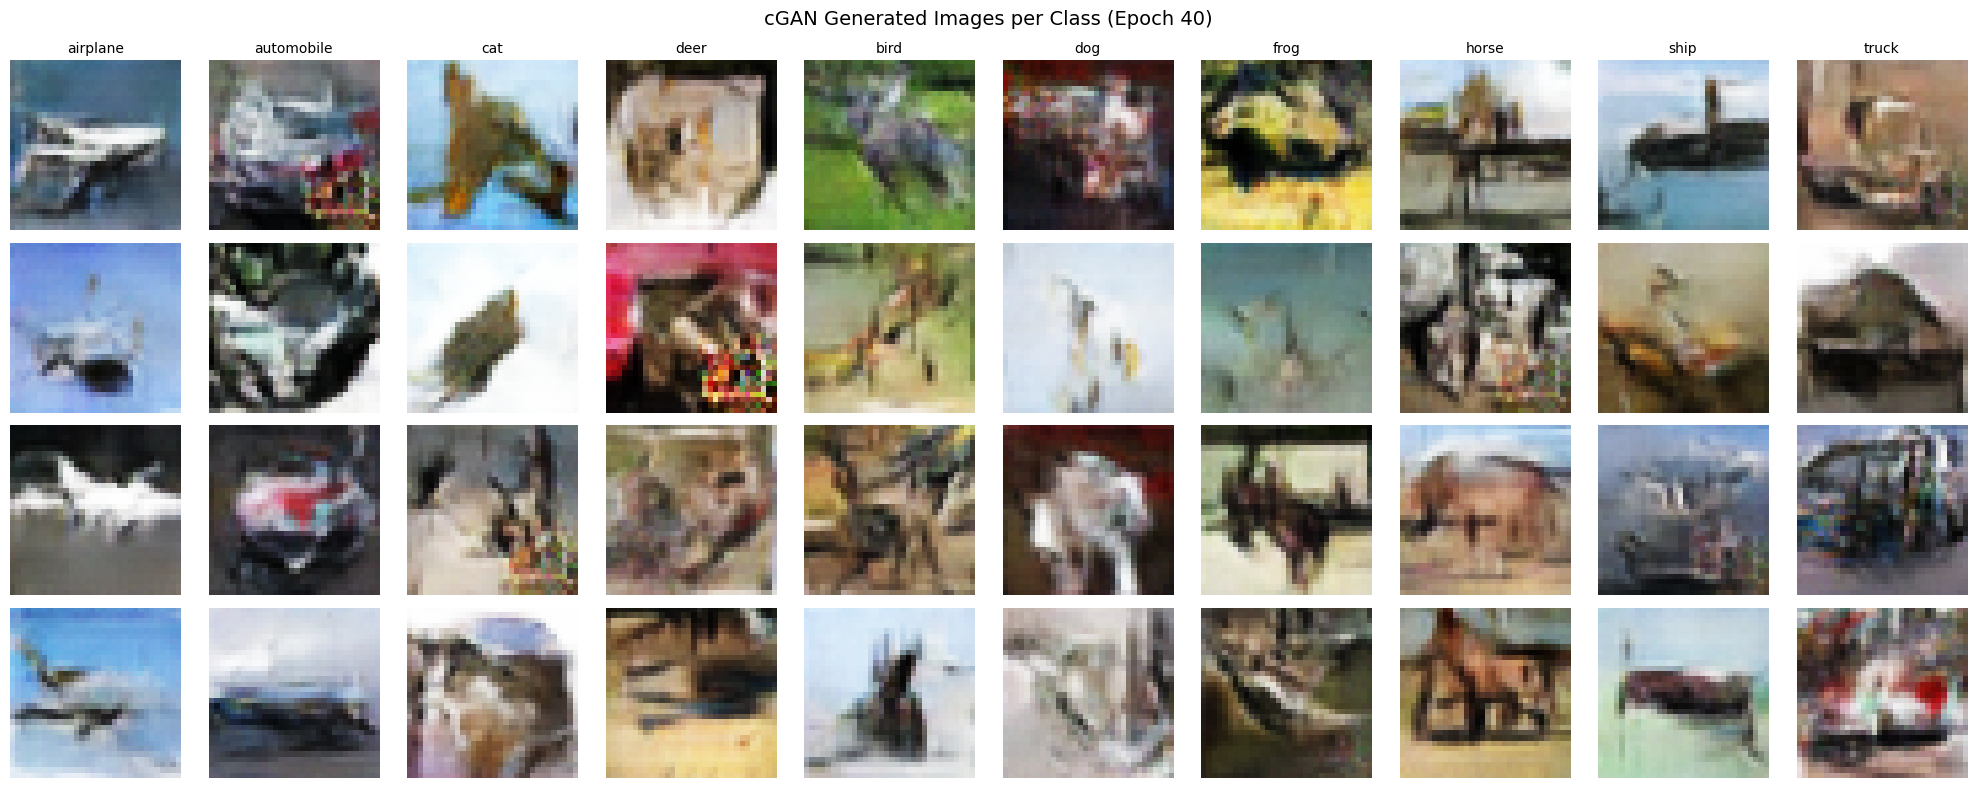

In [16]:
generator.load_state_dict(torch.load('model_weights/generator_epoch40.pth', map_location='cpu'))
generator.eval()

classes = ["airplane", "automobile", "cat", "deer", "bird", "dog", "frog", "horse", "ship", "truck"]

fig, axes = plt.subplots(4, 10, figsize=(20, 8))

with torch.no_grad():
    for row in range(4):
        sample_noise = torch.randn(10, latent_dim)
        sample_labels = torch.arange(10)
        sample_labels_onehot = nn.functional.one_hot(sample_labels, num_classes).float()
        sample_images = generator(sample_noise, sample_labels_onehot)
        sample_images = (sample_images + 1) / 2
        
        for col in range(10):
            axes[row, col].imshow(sample_images[col].cpu().permute(1,2,0).numpy())
            if row == 0:
                axes[row, col].set_title(classes[col], fontsize=10)
            axes[row, col].axis("off")

plt.suptitle("cGAN Generated Images per Class (Epoch 40)", fontsize=14)
plt.tight_layout()
plt.savefig('generated_images.png', dpi=150)
plt.show()